### Image Processing With a CNN 
Distinguish images of dogs from cats<br>
Data:<br>
https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition

### CNN model diagnostics

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import time

In [2]:
# prepare dir for unzipped images
os.makedirs('my_images', exist_ok=True)
unzip_dn = 'my_images'
train_dn = unzip_dn+'/train'
test_dn = unzip_dn+'/test'

# set variables
random_state = 123
np.random.seed(random_state)
tf.random.set_seed(random_state)
im_size = 224
batch_size = 64
epochs = 100

In [3]:
# unzip data if not already present
if not os.path.isdir(train_dn):
  print('unzipping...')
  with zipfile.ZipFile('drive/MyDrive/input/dogs-vs-cats-redux-kernels-edition/train.zip', 'r') as zz:
    zz.extractall(unzip_dn)
  with zipfile.ZipFile('drive/MyDrive/input/dogs-vs-cats-redux-kernels-edition/test.zip', 'r') as zz:
    zz.extractall(unzip_dn)
  print('done')
else:
  print('image directory present')

# get list of train + test images
train_im_list = os.listdir(train_dn)
test_im_list = os.listdir(test_dn)

image directory present


In [4]:
# training data: get image labels from file name
label_list = []
for file in os.listdir(train_dn):
  if (file.split('.')[0]=='dog'): label_list.append(str(1))
  elif (file.split('.')[0]=='cat'): label_list.append(str(0))
  
# training data: get df of images and labels
df = pd.DataFrame({'filename':train_im_list, 'label':label_list})
print(df.shape)
df.head()

(25000, 2)


,filename,label
0,dog.8289.jpg,1
1,cat.6354.jpg,0
2,dog.5338.jpg,1
3,cat.11123.jpg,0
4,dog.11425.jpg,1


In [5]:
# train val split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=random_state)
print('train:', train_df.shape, '; val:', val_df.shape)

train: (20000, 2) ; val: (5000, 2)


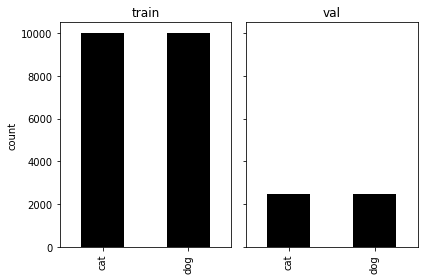

In [6]:
# label class distribution; verify stratified train/val split
fig, axs = plt.subplots(1,2, sharey=True)
train_df['label'].map({'1':'dog', '0':'cat'}).value_counts().plot(kind='bar', color='k', ax=axs[0])
val_df['label'].map({'1':'dog', '0':'cat'}).value_counts().plot(kind='bar', color='k', ax=axs[1])
axs[0].set(title='train', ylabel='count')
axs[1].set(title='val')
fig.tight_layout()
plt.show()

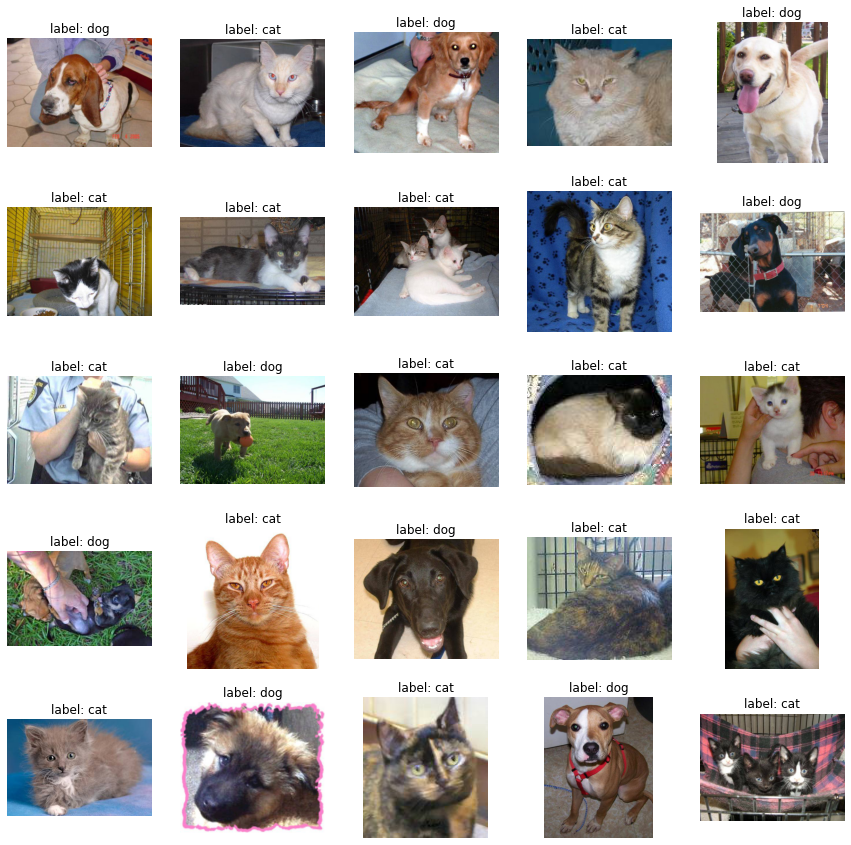

In [7]:
# visualize train data; plot 25 samples
fig, axs = plt.subplots(5, 5, figsize = (15, 15))
for ii, ax in enumerate(axs.flat):
  ax.imshow(Image.open(os.path.join(train_dn, train_im_list[ii])))
  ax.axis('off')
  ax.set_title('label: {}'.format(train_im_list[ii].split('.')[0]))
plt.show()
fig.savefig('train_example.pdf', format='pdf', bbox_inches='tight')

In [8]:
# prepare val data
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

val_gen = val_datagen.flow_from_dataframe(val_df, directory=train_dn, x_col='filename', y_col=None, 
                                          target_size=(im_size, im_size),
                                          batch_size=batch_size, class_mode=None, shuffle=False)

Found 5000 validated image filenames.


In [9]:
# reconstruct model
model = tf.keras.models.load_model('drive/MyDrive/model_cnn3')
# predictions on val data
val_probs = model.predict(val_gen).flatten()
val_preds = np.round(val_probs).astype(int)

In [10]:
# gather results
val_results = pd.DataFrame({'filename':val_gen.filenames, 'proba':val_probs, 'pred':val_preds})
val_results['label'] = val_results['filename'].str[:3].map({'cat':0, 'dog':1})
val_results

,filename,proba,pred,label
0,cat.4006.jpg,0.007901,0,0
1,dog.7293.jpg,1.000000,1,1
2,dog.2235.jpg,0.999990,1,1
3,cat.10067.jpg,0.000112,0,0
4,dog.6128.jpg,0.999852,1,1
...,...,...,...,...
4995,dog.8328.jpg,1.000000,1,1
4996,dog.1061.jpg,1.000000,1,1
4997,dog.2113.jpg,0.999994,1,1
4998,dog.9580.jpg,0.999886,1,1


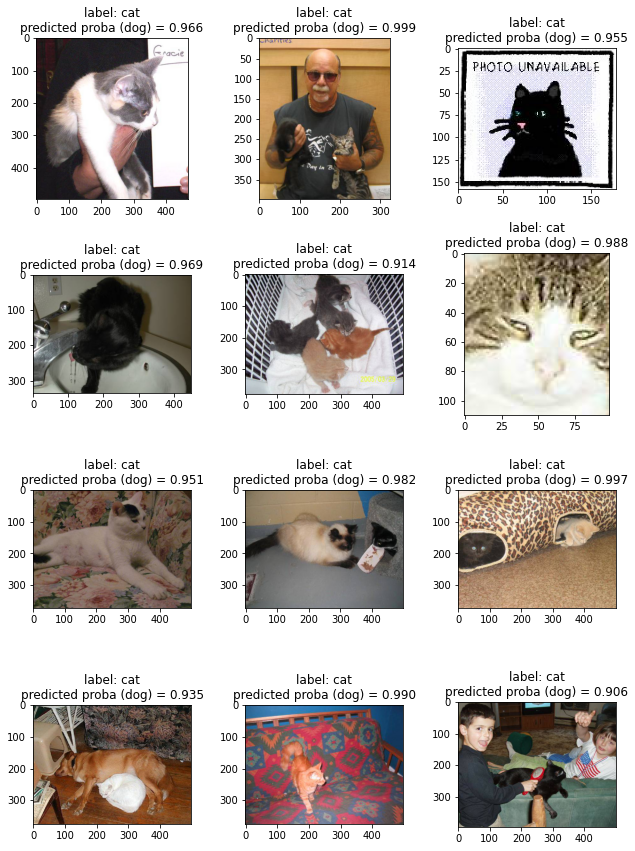

In [11]:
# predicted with high confidence dogs, but were cats
cat_wrong = val_results[(val_results['proba']>0.9) & (val_results['label']==0)]
fig, axs = plt.subplots(4, 3, figsize = (9, 12))
for ii, ax in enumerate(axs.flat):
  ax.imshow(Image.open(os.path.join(train_dn, cat_wrong['filename'].to_list()[ii])))
  # ax.axis('off')
  ax.set_title('label: {}\npredicted proba (dog) = {:.3f}'.format(cat_wrong['filename'].to_list()[ii].split('.')[0],
                                                                  cat_wrong['proba'].to_list()[ii]))
fig.tight_layout()
plt.show()
fig.savefig('not_dogs.pdf', format='pdf', bbox_inches='tight')

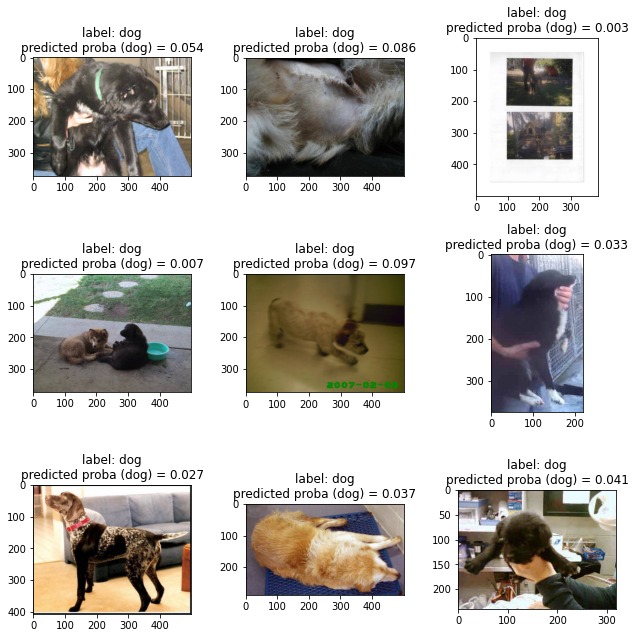

In [12]:
# predicted with high confidence cats, but were dogs
dog_wrong = val_results[(val_results['proba']<0.1) & (val_results['label']==1)]
fig, axs = plt.subplots(3, 3, figsize = (9, 9))
for ii, ax in enumerate(axs.flat):
  ax.imshow(Image.open(os.path.join(train_dn, dog_wrong['filename'].to_list()[ii])))
  # ax.axis('off')
  ax.set_title('label: {}\npredicted proba (dog) = {:.3f}'.format(dog_wrong['filename'].to_list()[ii].split('.')[0],
                                                                  dog_wrong['proba'].to_list()[ii]))
fig.tight_layout()
plt.show()
fig.savefig('not_cats.pdf', format='pdf', bbox_inches='tight')

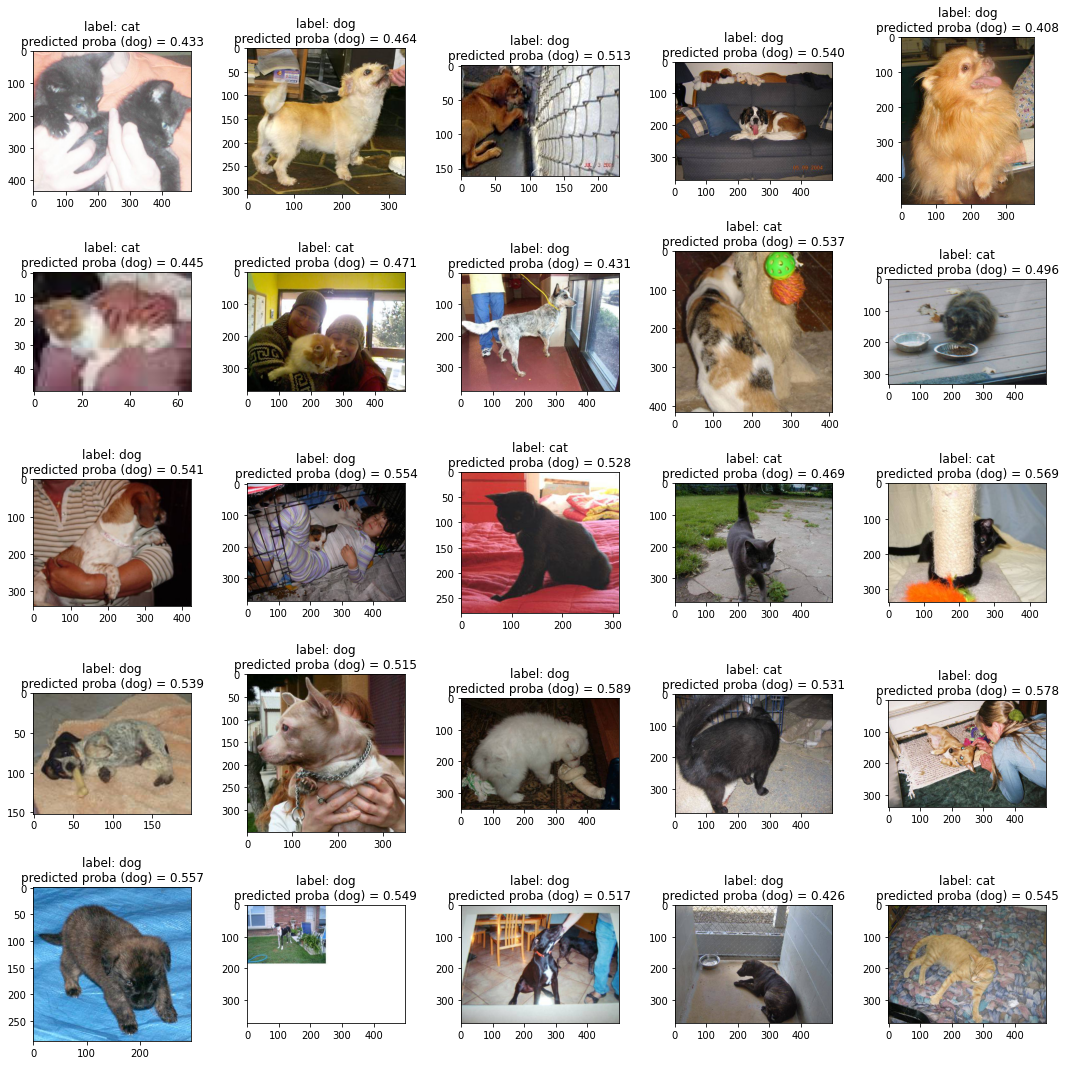

In [13]:
# most uncertain
uncertain = val_results[(val_results['proba']>0.4) & (val_results['proba']<0.6)]
fig, axs = plt.subplots(5, 5, figsize = (15, 15))
for ii, ax in enumerate(axs.flat):
  ax.imshow(Image.open(os.path.join(train_dn, uncertain['filename'].to_list()[ii])))
  # ax.axis('off')
  ax.set_title('label: {}\npredicted proba (dog) = {:.3f}'.format(uncertain['filename'].to_list()[ii].split('.')[0],
                                                                  uncertain['proba'].to_list()[ii]))
fig.tight_layout()
plt.show()
fig.savefig('uncertain.pdf', format='pdf', bbox_inches='tight')